In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import datetime, timedelta
import os                                  # Used to convert png to other format
import rpnpy.librmn.all as rmn             # Module to read RPN files
from rpnpy.rpndate import RPNDate, RPNDateRange
from rotated_lat_lon import RotatedLatLon  # Module to project field on native grid (created by Sasha Huziy)
import cartopy.crs as ccrs                 # Import cartopy ccrs
import cartopy.feature as cfeature         # Import cartopy common features

2021-04-19 00:00:00
Starting the plot for F000 20210419 00Z
449014400
{}
260.0 53.0 275.0 50.0
2021-04-19 01:00:00
Starting the plot for F001 20210419 01Z
449015300
2021-04-19 02:00:00
Starting the plot for F002 20210419 02Z
449016200
2021-04-19 03:00:00
Starting the plot for F003 20210419 03Z
449017100
2021-04-19 04:00:00
Starting the plot for F004 20210419 04Z
449018000
2021-04-19 05:00:00
Starting the plot for F005 20210419 05Z
449018900
2021-04-19 06:00:00
Starting the plot for F006 20210419 06Z
449019800
2021-04-19 07:00:00
Starting the plot for F007 20210419 07Z
449020700
2021-04-19 08:00:00
Starting the plot for F008 20210419 08Z
449021600
2021-04-19 09:00:00
Starting the plot for F009 20210419 09Z
449022500
2021-04-19 10:00:00
Starting the plot for F010 20210419 10Z
449023400
2021-04-19 11:00:00
Starting the plot for F011 20210419 11Z
449024300
2021-04-19 12:00:00
Starting the plot for F012 20210419 12Z
449025200
2021-04-19 13:00:00
Starting the plot for F013 20210419 13Z
44902

2021-04-20 12:00:00
Starting the plot for F024 20210420 12Z
449046800
2021-04-20 13:00:00
Starting the plot for F025 20210420 13Z
449047700
2021-04-20 14:00:00
Starting the plot for F026 20210420 14Z
449048600
2021-04-20 15:00:00
Starting the plot for F027 20210420 15Z
449049500
2021-04-20 16:00:00
Starting the plot for F028 20210420 16Z
449050400
2021-04-20 17:00:00
Starting the plot for F029 20210420 17Z
449051300
2021-04-20 18:00:00
Starting the plot for F030 20210420 18Z
449052200
2021-04-20 19:00:00
Starting the plot for F031 20210420 19Z
449053100
2021-04-20 20:00:00
Starting the plot for F032 20210420 20Z
449054000
2021-04-20 21:00:00
Starting the plot for F033 20210420 21Z
449054900
2021-04-20 22:00:00
Starting the plot for F034 20210420 22Z
449055800
2021-04-20 23:00:00
Starting the plot for F035 20210420 23Z
449056700
2021-04-21 00:00:00
Starting the plot for F036 20210421 00Z
449057600
2021-04-21 01:00:00
Starting the plot for F037 20210421 01Z
449058500
2021-04-21 02:00:00


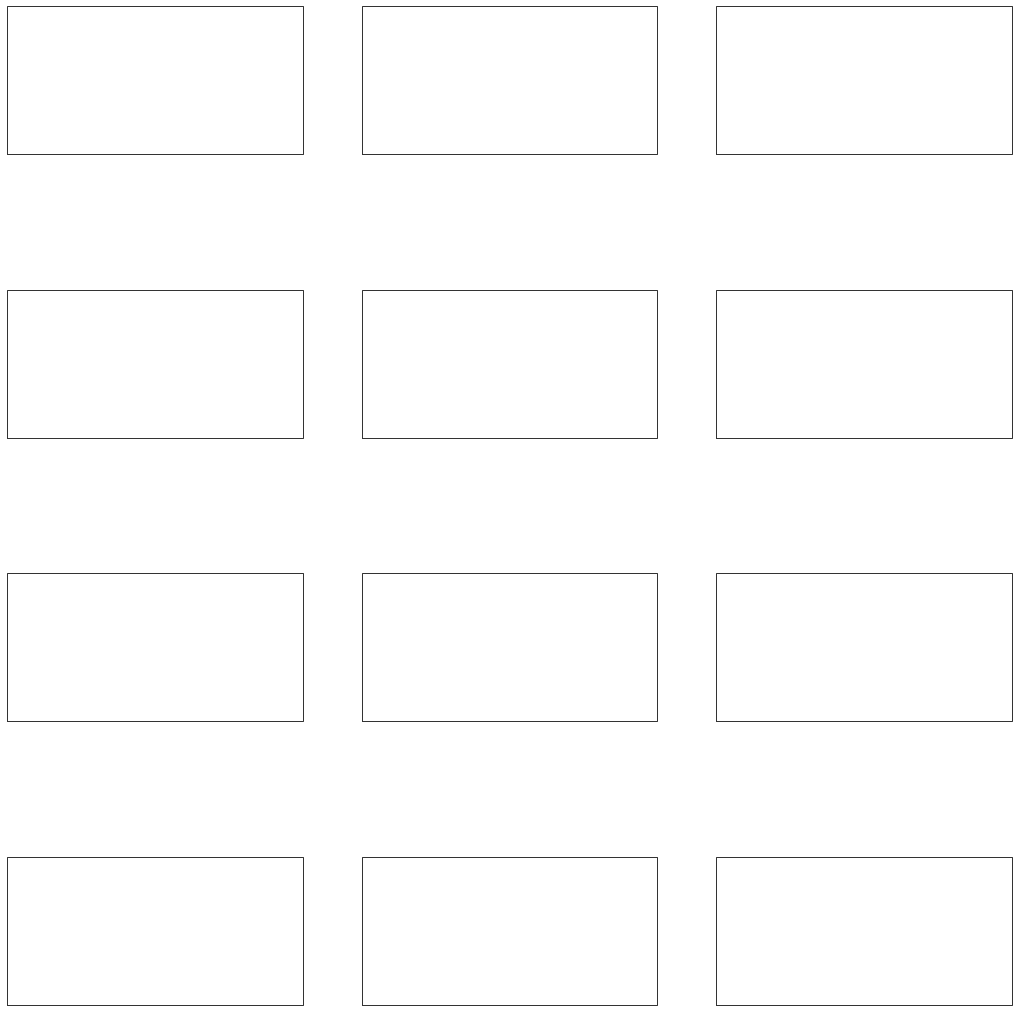

In [13]:
'''
List of Variables:
## 2D ##
PX: 
MPNC:
MPNR:
HU: Humidite specifique
MPQC:
MPQR:
QT1:
GZ: Geopotential Height
TT: Air Temperature
HR: Relative Humidity
WW: Vertical Motion
UU: Wind U
VV: Wind V
QR: Relative Vorticity
ZZ:
QTI1:
QMI1:
NTI1:
BMI1:
PN: Sea level pressure

## 3D ##
TD:
TT: Air Temperature
HU: Humidite specifique
WW: Vertical Motion
UU: Wind U
VV: Wind V
GZ: Geopotential Height
QQ: Absolute Vorticity
P0: Surface Pressure
ES: Dew Point Depression

'''
typ = 'pres'
typ = 'model'

y = 2021
m = 4
d = 19
h = [0,6,12,18]      

f_hrdps = '/chinook/cruman/Data/HRDPS_SAJESS'
#f_ERA = '/BIG3/data/ReAnalysis/ERA5/2D_Fields/ERA5_202104'
f_ERA = '/home/cruman/Data/ERA5'
file_var = 'era5_202104_TT'
# Era has one file with the hourly value of the entire month

# Same file name for pres and model
#filename = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{h[0]:02d}_{prev[5]:03d}_zoom"

varname = "TT"
unit = r"${\rm ^\circ C}$"     # r + symbol of the unit of the values ("m", "%", "${\rm ^\circ C}$", "m/s", "${\rm W/m^2}$", ...)
val_min  =  -6
val_max  =  6
val_int  =  1
cmap = plt.cm.coolwarm
ip1=76696048  # For TT 1.5m
aux_data = []
aux_title = []
proj = True
for hour in h:
    aux_data = []
    aux_title = []
    dt = datetime(y, m, d, hour)
    for prev in range(0,48+1):
        aux = dt + timedelta(hours=prev)
        print(aux)
        title = f"F{prev:03d} {aux.year}{aux.month:02d}{aux.day:02d} {aux.hour:02d}Z"
        
        print(f"Starting the plot for {title}")
        #read the file.
        filename_era = f"{f_ERA}/era5_interp_HRDPS_{y}{m:02d}_{varname}"
        filename_hrdps = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{hour:02d}_{prev:03d}_zoom"
        # Openning the files
        # I have one file per hour
        field_era, tics, lat, lon = readFileERA(filename_era, varname, ip1, RPNDate(aux))              
        field_gem, tics, lat, lon = readFileGEM(filename_hrdps, varname, ip1, RPNDate(aux))
        
        if proj:
            # 2-D Mapping - if needed
            # -----------------------
            # Get positions of rotated equator from IG1-4 of the tictac's
            (Grd_xlat1,Grd_xlon1,Grd_xlat2,Grd_xlon2) = rmn.cigaxg('E', tics['ig1'],tics['ig2'],tics['ig3'],tics['ig4'])
            # Use Sasha's RotatedLatLon to get the rotation matrix
            rll = RotatedLatLon( lon1=Grd_xlon1, lat1=Grd_xlat1, lon2=Grd_xlon2, lat2=Grd_xlat2) # the params come from gemclim_settings.nml
            # Use Sasha's get_cartopy_projection_obj to get the cartopy object for the projection and domain defined by the coordinates
            myProj = rll.get_cartopy_projection_obj()
            proj = False
            
            f, axs = plt.subplots(4, 3, figsize=(18, 20), subplot_kw={'projection': myProj})
            
        
        
        #for i, ax in enumerate(axs.flat):
            # Plot the figure
        #print(prev%12)
        aux_data.append(field_gem-field_era)
        aux_title.append(title)
        #ax[prev%12] = plotVar(ax[prev%12], lon, lat, field, cmap, val_max, val_min, val_int, unit, title)
        
        if (prev+1)%12 == 0:
            # Close the figure and start a new instance                        
            
            if prev != 0:
                axs, im = plotVar(axs, lon, lat, aux_data, cmap, val_max, val_min, val_int, unit, aux_title)
                f.subplots_adjust(wspace=0.15, hspace=0.2)
                
                # Colorbar
                cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
                ints = ( (val_max-val_min+val_int) / val_int)
                color_ticks = np.linspace(val_min, val_max, int(ints))
                cb = f.colorbar(mappable=im, cax=cbar_ax, ticks=color_ticks,orientation="vertical",pad=0.05,shrink=0.8, extend="both")
                #cb.set_label('Accumulated Snow (mm) / Wind Speed (km/h)', size=24)
                cbar_ax.tick_params(labelsize=20)
                                
                cbar_ax.set_title(unit, fontsize=20)
                
                plt.suptitle(f'Difference for {varname}: HRDPS - ERA5', fontsize=24, y=0.95)
                
                # Save fig
                #plt.show()
                plt.savefig(f'fig_DIFF_{varname}_Hour{hour}_prev{prev+1:02d}.png')
                plt.close()
                #sys.exit()
                aux_data = []
                aux_title = []
                
            #if prev != 48:
                # Create a new instance of the plot
                f, axs = plt.subplots(4, 3, figsize=(18, 20), subplot_kw={'projection': myProj})                                

                  

In [2]:
def readFileERA(filename, var, ip1, datev):
    #print(date.strftime("%Y%m%d %H%M%S"))
    print(datev.datev)
    # Read one record
    # ---------------
    fid = rmn.fstopenall(filename,rmn.FST_RO)   # Open the file
    rec = rmn.fstlir(fid,nomvar=var,datev=datev.datev,ip1=ip1)        # Read the full record of variable 'varname'
    field = rec['d']#[i1:i2,j1:j2]                            # Assign 'field' to the data of 'varname'

    mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
    latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information
    lat = latlondict['lat']#[i1:i2,j1:j2]                     # Assign 'lat' to 2-D latitude field
    lon = latlondict['lon']#[i1:i2,j1:j2]                    # Assign 'lon' to 2-D longitude field
    # Get grid rotation for projection of 2-D field for mapping -  if needed
    tics = rmn.fstlir(fid,nomvar='^^', ip1=rec['ig1'],ip2=rec['ig2'],ip3=rec['ig3']) # Read corresponding tictac's
    # Close the RPN file
    rmn.fstcloseall(fid) 
    
    return field, tics, lat, lon

def readFileGEM(filename, var, ip1, datev):
    # Read one record
    # ---------------
    fid = rmn.fstopenall(filename,rmn.FST_RO)   # Open the file
    rec = rmn.fstlir(fid,nomvar=var,datev=datev.datev,ip1=ip1)        # Read the full record of variable 'varname'
    field = rec['d']#[i1:i2,j1:j2]                            # Assign 'field' to the data of 'varname'

    mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
    latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information
    lat = latlondict['lat']#[i1:i2,j1:j2]                     # Assign 'lat' to 2-D latitude field
    lon = latlondict['lon']#[i1:i2,j1:j2]                    # Assign 'lon' to 2-D longitude field
    # Get grid rotation for projection of 2-D field for mapping -  if needed
    tics = rmn.fstlir(fid,nomvar='^^', ip1=rec['ig1'],ip2=rec['ig2'],ip3=rec['ig3']) # Read corresponding tictac's
    # Close the RPN file
    rmn.fstcloseall(fid) 
    
    return field, tics, lat, lon

In [5]:
def plotVar(axs, lon, lat, var, cmap, val_max, val_min, val_int, unit, title):
    xll, yll = lon[0, 0],lat[0, 0]
    xur, yur = lon[-1, -1],lat[-1, -1]
    
    for i, ax in enumerate(axs.flat):
    
        # Set geographic features    
        ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
        ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
        #ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
        #ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche riviÃ ̈res
        coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',facecolor='none', name='coastline') # C
        ax.add_feature(coast, edgecolor='black')
        states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none') # Couche provinces
        ax.add_feature(states_provinces, edgecolor='black')
        ax.set_extent([xll+2.1, xur-2.55, yll-0.65, yur+1.6])

        # Set color map
        #cmap = plt.cm.jet
        # Set min, max and interval for color plot
        ints = ( (val_max-val_min+val_int) / val_int)
        color_bnds  = np.linspace(val_min, val_max, int(ints))
        color_ticks = np.linspace(val_min, val_max, int(ints))
        norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)
        # Plot figure
        cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
        #cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
        # Plot colorbar
        #cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="vertical",pad=0.05,shrink=0.8, extend="both")
        #cb.ax.set_title(unit)
        # Plot title
        ax.set_title(title[i], fontsize=20)
    
    return axs, cs
    

In [8]:
#tics = rec
val_min  =  int(np.min(field))#980
val_max  =  int(np.max(field))#1030
val_int  =  int((val_max - val_min)/10)#5
unit = r"${\rm ^\circ C}$"     # r + symbol of the unit of the values ("m", "%", "${\rm ^\circ C}$", "m/s", "${\rm W/m^2}$", ...)
title = "2m Temperature"
# 2-D Mapping - if needed
# -----------------------
# Get positions of rotated equator from IG1-4 of the tictac's
(Grd_xlat1,Grd_xlon1,Grd_xlat2,Grd_xlon2) = rmn.cigaxg('E', tics['ig1'],tics['ig2'],tics['ig3'],tics['ig4'])
# Use Sasha's RotatedLatLon to get the rotation matrix
rll = RotatedLatLon( lon1=Grd_xlon1, lat1=Grd_xlat1, lon2=Grd_xlon2, lat2=Grd_xlat2) # the params come from gemclim_settings.nml
# Use Sasha's get_cartopy_projection_obj to get the cartopy object for the projection and domain defined by the coordinates
m = rll.get_cartopy_projection_obj()

{}
260.0 53.0 275.0 50.0


In [13]:
# Read one record
# ---------------
fid = rmn.fstopenall(filename,rmn.FST_RO)   # Open the file
rec = rmn.fstlir(fid,nomvar=varname,ip1=76696048)        # Read the full record of variable 'varname'
field = rec['d']#[i1:i2,j1:j2]                            # Assign 'field' to the data of 'varname'

mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information
lat = latlondict['lat']#[i1:i2,j1:j2]                     # Assign 'lat' to 2-D latitude field
lon = latlondict['lon']#[i1:i2,j1:j2]                    # Assign 'lon' to 2-D longitude field
# Get grid rotation for projection of 2-D field for mapping -  if needed
tics = rmn.fstlir(fid,nomvar='^^', ip1=rec['ig1'],ip2=rec['ig2'],ip3=rec['ig3']) # Read corresponding tictac's
# Close the RPN file
rmn.fstcloseall(fid) 

In [15]:
rmn.DecodeIp(76696048, 176265768, 0)

(FLOAT_IP(1.5, 1.5, 4), FLOAT_IP(10.5, 10.5, 10), FLOAT_IP(0.0, 0.0, 10))

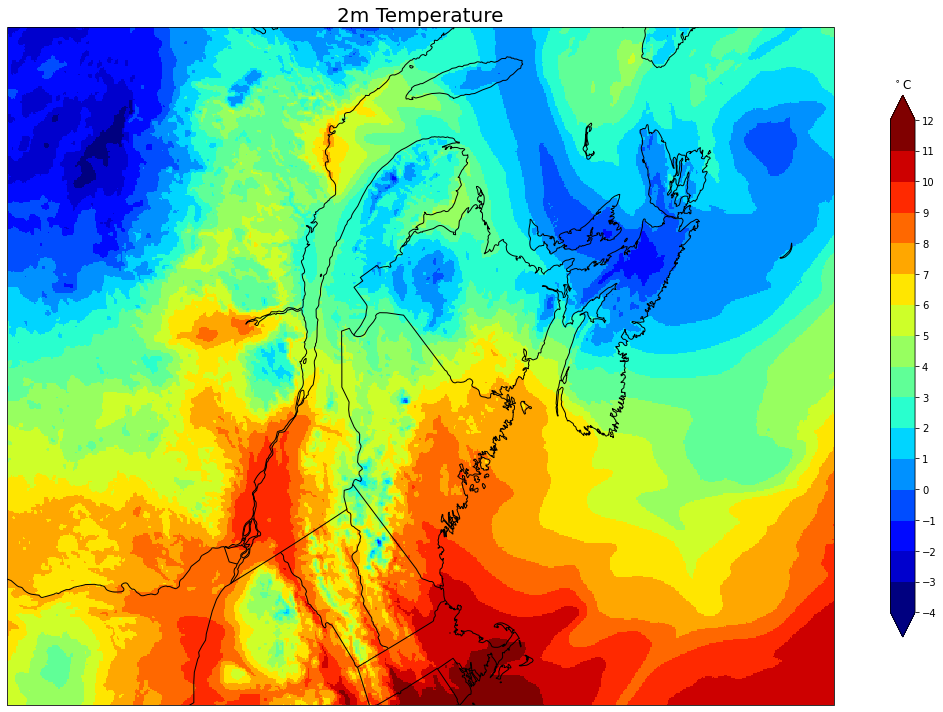

In [74]:
figsize = (16, 10)      # Figure size
fig = plt.figure(figsize=figsize) # Set projection defined by the cartopy object
ax = plt.axes(projection=m)
#ax = plt.axes(projection=myLambert)
# Set corners of the maps
xll, yll = m.transform_point(lon[0, 0],lat[0, 0],ccrs.PlateCarree())
xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())
xll, yll = lon[0, 0],lat[0, 0]
xur, yur = lon[-1, -1],lat[-1, -1]
# Set geographic features
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
#ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
#ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche riviÃ ̈res
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',facecolor='none', name='coastline') # C
ax.add_feature(coast, edgecolor='black')

states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none') # Couche provinces
ax.add_feature(states_provinces, edgecolor='black')
ax.set_extent([xll+2.1, xur-2.55, yll-0.65, yur+1.6])
#ax.set_extent([xll, xur, yll, yur])
# Set colors
# ----------
# Set color map
cmap = plt.cm.jet
# Set min, max and interval for color plot
ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_ticks = np.linspace(val_min, val_max, int(ints))
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)
# Plot figure
cs = plt.pcolormesh(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="vertical",pad=0.05,shrink=0.8, extend="both")
cb.ax.set_title(unit)
# Plot title
plt.title(title, fontsize=20)
# To help the layout of the figure after saving
fig.canvas.draw()
plt.tight_layout()  # To help with the layout of the figure after saving
# Save figure
plt.show()
#plt.savefig('NB_small_domain.png')